# Clustering Example

In this example we cluster a short trajectory (1000 frames) of the disordered peptide
[hiAPP](https://www.ncbi.nlm.nih.gov/pubmed/24021023)

We create a normalized covariance matrix using four different metrics:
    - Radius of gyration
    - Exposed solvent surface
    - Asphericity
    - End-to-end distance

<a id='Table of Contents'></a><h3>Table of Contents</h3>
<a href='#load_env'>Load Environment</a> 
<a href='#download_data'>Donwload Data</a>  
<a href='#load_traj'>Loading the Trajectory</a>  
<a href='#vis_traj'>Quick Trajectory Visualization</a> 
<a href='#clustering'>Clustering</a> 
<a href='#pdb_repr'>Extract PDB Files for Representative Structures</a>  
<a href='#calc_rg'>Calculate Radius of Gyration</a>  


(<a href='#Table of Contents'>Top</a>)<a id='load_env'></a><h3>Load Environment</h3>

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

import os
import sys
import subprocess
import numpy as np
import MDAnalysis as mda
import nglview
from tqdm import tqdm
import pathos
import multiprocessing
from scipy.cluster.hierarchy import dendrogram

from idpflex.cnextend import load_tree
from idpflex.cluster import cluster_trajectory
from idpflex.properties import (SaxsProperty, SecondaryStructureProperty, ResidueContactMap,
                                RadiusOfGyration, EndToEnd, propagator_size_weighted_sum)
from idpflex.utils import write_frame
from idpflex.bayes import fit_to_depth

(<a href='#Table of Contents'>Top</a>)<a id='download_data'></a><h3>Donwload Data</h3>

It's assumed <code>git</code> is installed in your system. Otherwise,
[follow instructions](http://idpflex.readthedocs.io/en/latest/installation.html#testing-tutorials-data)
to download and unpack your data to <code>/tmp/idpflex_data</code>.

In [3]:
%%bash
idpflex_data_dir="/tmp/idpflex_data"
if [ -d "${idpflex_data_dir}" ]; then
    cd ${idpflex_data_dir}
    git pull --rebase
else
    git clone https://github.com/jmborr/idpflex_data ${idpflex_data_dir}
fi

Cloning into '/tmp/idpflex_data'...


In [4]:
idpflex_data_dir = '/tmp/idpflex_data'
data_dir = os.path.join(idpflex_data_dir, 'data', 'simulation')
print(data_dir)

/tmp/idpflex_data/data/simulation


(<a href='#Table of Contents'>Top</a>)<a id='load_traj'></a><h3>Loading the Trajectory</h3>

In [5]:
simulation = mda.Universe(os.path.join(data_dir, 'hiAPP.pdb'),
                          os.path.join(data_dir, 'hiAPP.xtc'))
print('Number of frames in trajectory is ', simulation.trajectory.n_frames)

('Number of frames in trajectory is ', 1000)


/sw/conda/miniconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


(<a href='#Table of Contents'>Top</a>)<a id='vis_traj'></a><h3>Quick Trajectory Visualization</h3>

In [6]:
w_show = nglview.show_mdanalysis(simulation)
w_show

NGLWidget(count=1000)

(<a href='#Table of Contents'>Top</a>)<a id='clustering'></a><h3>Clustering</h3>

We cluster the trajectory in two steps:
1. cluster the 1000 frames into 100 small clusters, producing 100 representative structures
2. cluster all 100 representative structures in a hierarchichal tree.

The first step will be obtained by splicing the trajectory into segments of 100 frames, and obtaining 10 representatives for each segment. Thus, we obtain a total of 100 representatives. See [clustering](http://idpflex.readthedocs.io/en/latest/idpflex/cluster.html) for more info.

The two steps process makes more sense with large trajectories, for instance, a trajectory of $10^5$ frames that we cluster into 1000 representatives.

In [7]:
cl = cluster_trajectory(simulation, segment_length=100, n_representatives=100)

Clustering the trajectory:
Creating 100 representatives by partitioning 1000 frames into 10 segments
and retrieving 10 representatives from each segment.
    

100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


(<a href='#Table of Contents'>Top</a>)<a id='pdb_repr'></a><h3>Extract PDB Files for Representative Structures</h3>

We extract PDB files for each of the 100 representatives and store under directory `/tmp/PDB`

In [8]:
pdb_names = ['/tmp/PDB/conf_{}.pdb'.format(idx) for idx in cl.idx]

In [9]:
subprocess.call(['mkdir', '-p', '/tmp/PDB'])  # directory to store the PDB files
for idx, name in tqdm(list(zip(cl.idx, pdb_names))):
    write_frame(simulation, idx, name)

100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


(<a href='#Table of Contents'>Top</a>)<a id='calc_rg'></a><h3>Calculate Radius of Gyration</h3>

We calculate $Rg$ for each representative and propagate up the cluster tree. Property name is `'rg'`. This radius of gyration does not take into account the hydration layer.  
We plot a histogram of Rg for the 100 representatives.

<IPython.core.display.Javascript object>


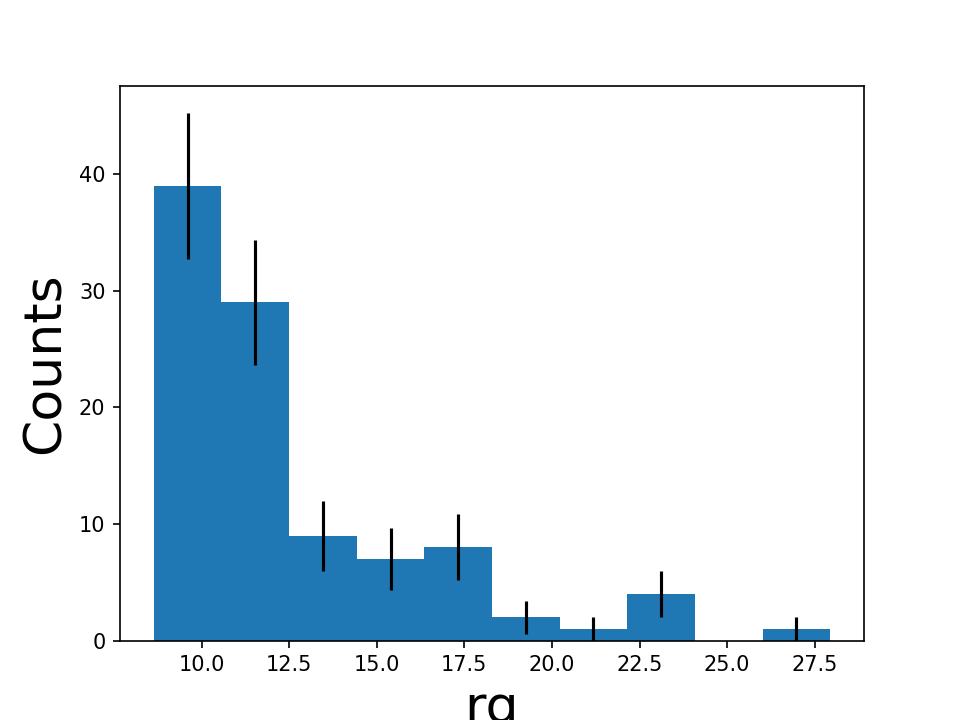

In [10]:
rg_properties = [RadiusOfGyration().from_pdb(name) for name in pdb_names]  # Rg for each representative
propagator_size_weighted_sum(rg_properties, cl.tree)
cl.tree.root['rg'].plot(kind='histogram', errors=True)

(<a href='#Table of Contents'>Top</a>)<a id='calc_rg'></a><h3>Calculate end-to-end distance</h3>

We calculate end-to-end for each representative and propagate up the cluster tree. Property name is `'end_to_end'`.  
We plot a histogram of `'end_to_end'` for the 100 representatives.

<IPython.core.display.Javascript object>


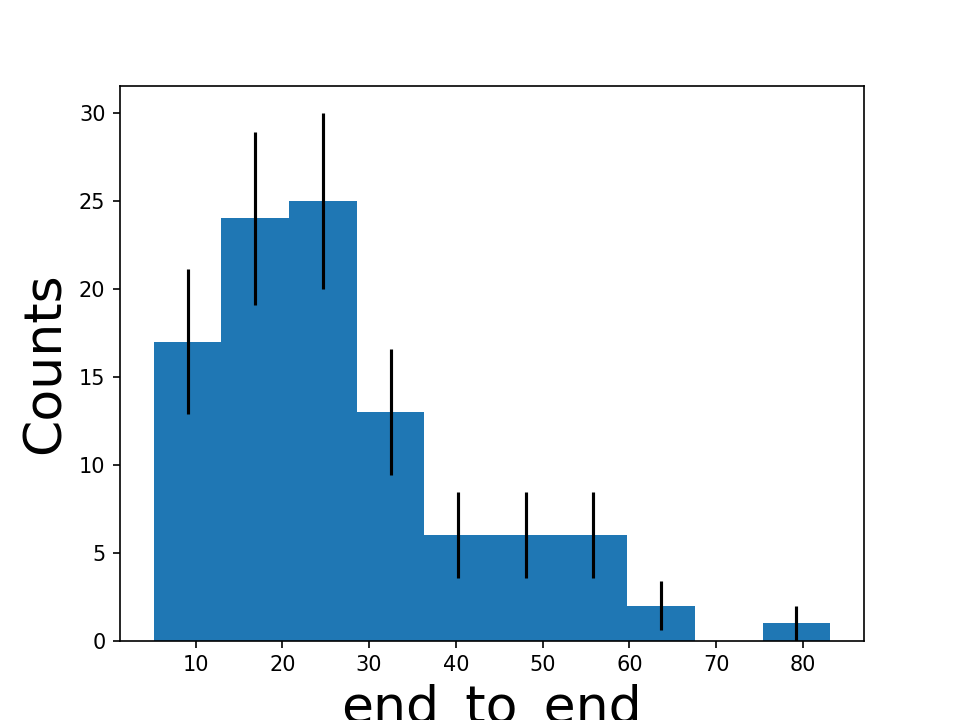

In [14]:
e2e_properties = [EndToEnd().from_pdb(name) for name in pdb_names]  # Rg for each representative
propagator_size_weighted_sum(e2e_properties, cl.tree)
cl.tree.root['end_to_end'].plot(kind='histogram', errors=True)